In [1]:
import sys
sys.path.append("/home/groups/ZuckermanLab/jalim/instalLocal/o2vae/")
import importlib
import train_loops
import run
import torch
from utils import utils
import wandb
import logging
import os 
from pathlib import Path
from configs.config_mefs import config
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# print(f'Using Device: {device}')

## Get data and sample images: Mouse Embryonic Fibroblasts (MEF)

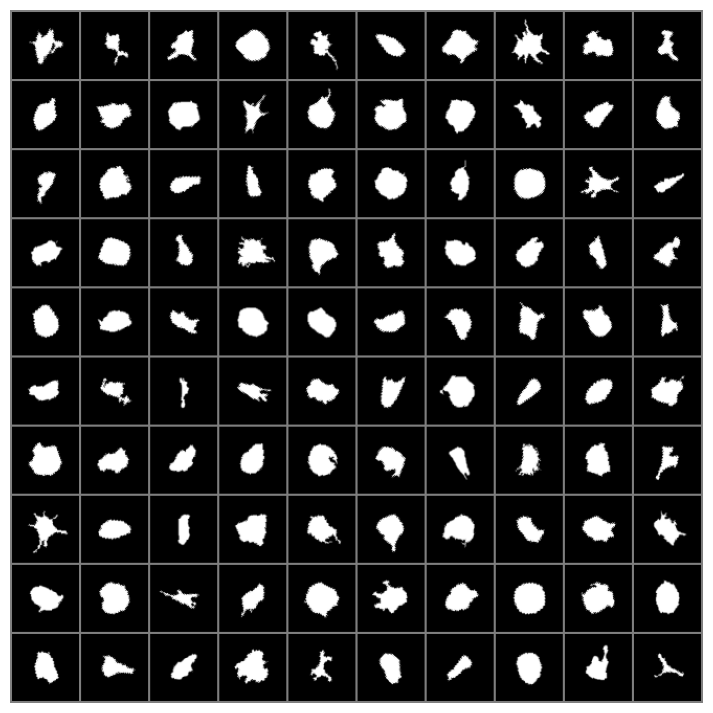

In [2]:
importlib.reload(utils)

dset, loader, dset_test, loader_test = run.get_datasets_from_config(config) # get datasets specified by config
data_imgs, data_imgs_test = dset.tensors[0], dset_test.tensors[0]
fig, axs = utils.plot_sample_data(loader)
fig

## Build model

In [3]:
config.model.encoder.n_channels=dset[0][0].shape[0]  # image channels
# config.model.zdim=8
model = run.build_model_from_config(config)

## Get pretrained model weights
**Important** change the below variable `dir_home` to point at.

In [4]:
dir_home = "/home/groups/ZuckermanLab/jalim/instalLocal/o2vae/"
pretrained_model_path = os.path.join(dir_home, "wandb/pretrained_models/model_mefs.pt")

In [5]:
print(f"Loading pretrained model {pretrained_model_path}")
model_checkpoint = torch.load(pretrained_model_path)
model.to(device).cpu().train()       # if keys don't match, try many combinations of putting it on and off cuda
missing_keys, unexpected_keys = model.load_state_dict(model_checkpoint['model_state_dict'], strict=False)
assert all(['_basisexpansion' in k for k in missing_keys]) # checking that the only missing keys from the state_dict are this one type

Loading pretrained model /home/groups/ZuckermanLab/jalim/instalLocal/o2vae/wandb/pretrained_models/model_mefs.pt


## Test reconstruction quality
Good reconstruction of the original image is one indicator that the representations are decent.

For VAE models, it is expected that there's some bluriness for finer surface features. 

Left: reconstructions.
Right: reconstructions where output is re-aligned to the input. 


/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/o2vae_test/lib/python3.9/site-packages/torch/nn/functional.py:4404: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/groups/ZuckermanLab/jalim/instalLocal/anaconda3/envs/o2vae_test/lib/python3.9/site-packages/torch/nn/functional.py:4343: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


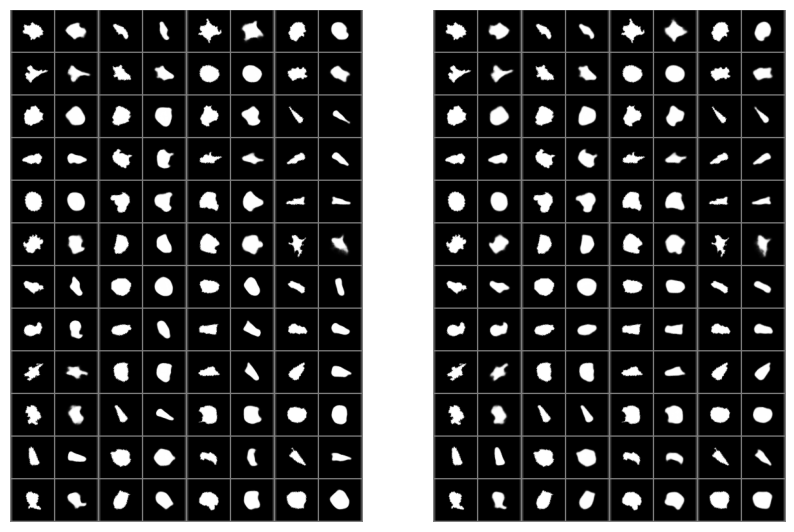

In [6]:
from utils import eval_utils
import matplotlib.pyplot as plt
importlib.reload(eval_utils)
model.eval().cpu() 

x, y = next(iter(loader_test))
reconstruct_grid = eval_utils.reconstruction_grid(model, x, align=False)
reconstruct_grid_aligned = eval_utils.reconstruction_grid(model, x, align=True)
fig, axs = plt.subplots(1, 2, figsize = (10, 10))
axs[0].imshow(reconstruct_grid)
axs[1].imshow(reconstruct_grid_aligned)
print("Left: reconstructions.")
print("Right: reconstructions where output is re-aligned to the input. ")
axs[0].set_axis_off();  axs[1].set_axis_off()

## Qualitative orientation invariance 
One qualitative test of embedding invariance is to sample an image with many rotations and flips; then verify that the reconstructed image has the same orientation. 

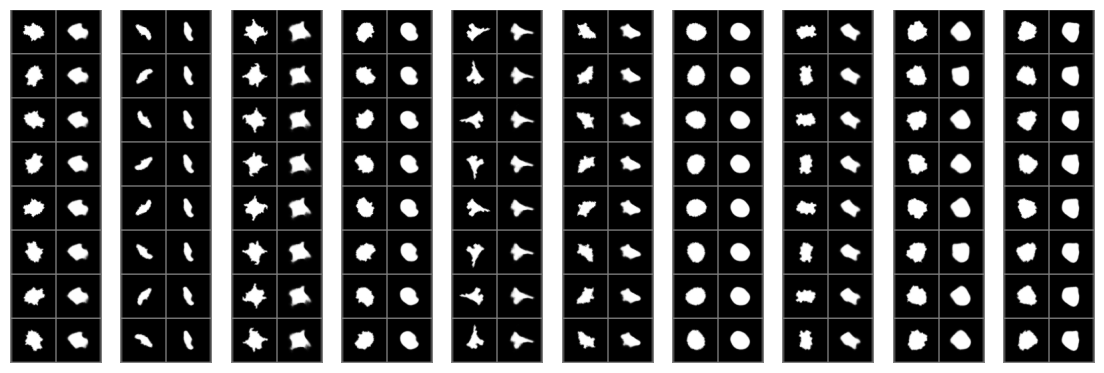

In [7]:
fig, axs = plt.subplots(1, 10, figsize = (14, 14))
for i in range(10):
    xs = eval_utils.rotated_flipped_xs(x[[i]], 90)[:,0]
    grid = eval_utils.reconstruction_grid(model, xs, align=False, ncol=2)
    axs[i].imshow(grid)
    axs[i].set_axis_off()

## Extract features
To do downstream analysis, fet the feature vector representations. 

In [8]:
embeddings, labels = utils.get_model_embeddings_from_loader(model, loader, return_labels=True)
embeddings_test, labels_test = utils.get_model_embeddings_from_loader(model, loader_test, return_labels=True)

100%|██████████| 26/26 [00:06<00:00,  3.97it/s]


## UMAP
Without labels, it's hard to interpret the UMAP, but it can be interesting to look at the structure. E.g. MEFs is more continuous than the O2-mnist case.

In [9]:
import umap
from utils import plotting_utils
reducer = umap.UMAP()

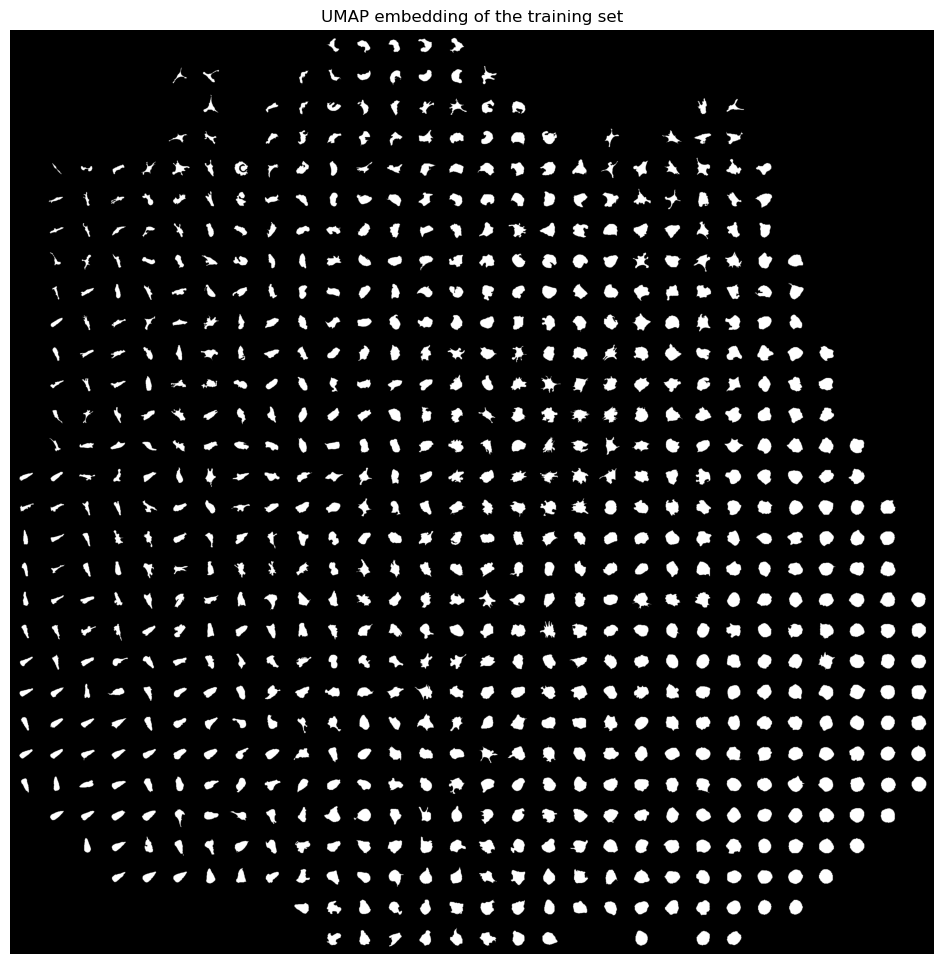

In [10]:
umap_embedding = reducer.fit_transform(embeddings)
data_x = loader.dataset.tensors[0]
grid, idxs = plotting_utils.get_embedding_space_embedded_images(umap_embedding,
                                                                data_x, 
                                                                n_ximgs=30, 
                                                                n_yimgs=30)
fig, axs = plt.subplots(figsize = (12, 12))
axs.set_axis_off()
axs.set_title('UMAP embedding of the training set')
axs.imshow(grid, cmap='gray')

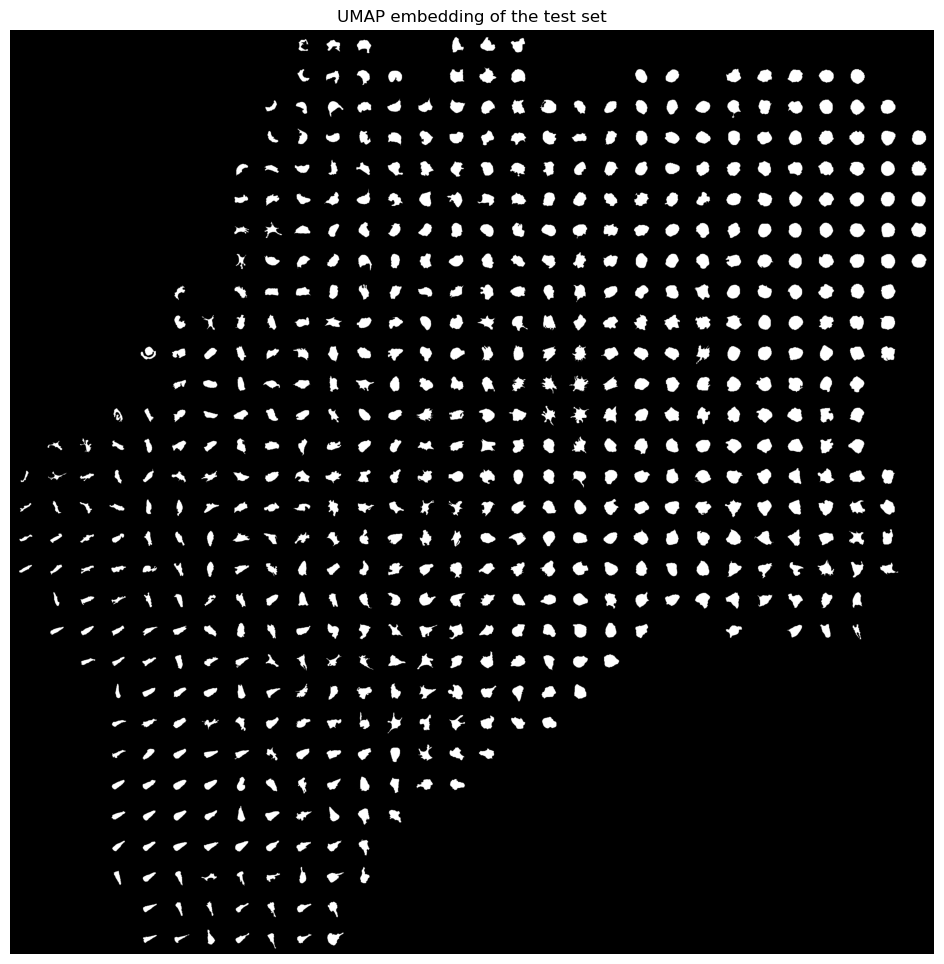

In [11]:
umap_embedding_test = reducer.fit_transform(embeddings_test)
data_x_test = loader_test.dataset.tensors[0]
grid_test, idxs_test = plotting_utils.get_embedding_space_embedded_images(umap_embedding_test,
                                                                data_x_test, 
                                                                n_ximgs=30, 
                                                                n_yimgs=30)
fig, axs = plt.subplots(figsize = (12, 12))
axs.set_axis_off()
axs.set_title('UMAP embedding of the test set')
axs.imshow(grid_test, cmap='gray')

## Clustering 

In [12]:
from utils import cluster_utils
importlib.reload(cluster_utils)

<module 'utils.cluster_utils' from '/home/groups/ZuckermanLab/jalim/instalLocal/o2vae/utils/cluster_utils.py'>

## k-nearest neighbour search
In the below figure, the first column is some selected images (default - the first 20 in the train set). The rest of the row are the k (10) nearest neigbours. 

The "nearest" is using euclidean distance in the embeddings space.  For a good embedding space, the nearest neighbours will be the most similarly-shaped objects in the data. 

You may see some samples that look like exact duplicates. We found that this is because in the original dataset, the micrographs were overlapping, so the same cell appeared in more than one micrographs. 

In [13]:
n_clusters=10
(labels_gmm, labels_kmeans), ((pca, cls_gmm), cls_kmeans), (centers_gmm, centers_kmeans), (scores_gmm, scores_kmeans)\
= cluster_utils.do_clusterering(embeddings, n_clusters=n_clusters)

In [14]:
method = "kmeans" ## choose whether to use the 'gmm' or 'kmeans' clusters
if method=='gmm':
    labels, centers, scores = labels_gmm, centers_gmm, scores_gmm
elif method=='kmeans':
    labels, centers, scores = labels_kmeans, centers_kmeans, scores_kmeans
else:
    raise ValueError()

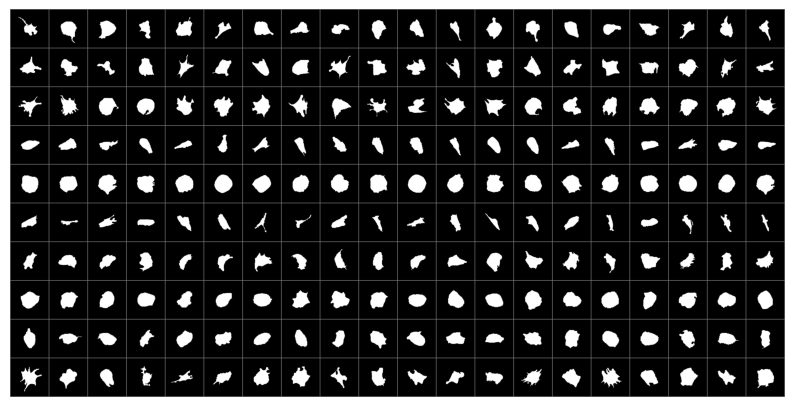

In [15]:
### sample images from the cluster - 
# param `cluster_sampling_method`. 
    # If `none` then random sample
    # If `uniform` then using `score` (likelihood object is in its cluster), sample uniformly 
    #      from high score (left) to low score (right)
    # If `top` sample high `score`
    # If `bottom` sample low `score`
    # if `std`, then remove samples that have the lowest `score`, where the threshold is 
    #     found by measuring std deviation of score, and thresholding with param stds_fit (default 1)
# param n_examples: number of samples per cluster

cluster_sampling_method='std'
n_examples=20
grid, counts = cluster_utils.make_sample_grid_for_clustering(labels,
                                                             data_imgs,
                                                             scores, 
                                                             n_examples=n_examples, 
                                                             stds_filt=1,
                                                             method=cluster_sampling_method,
                                                             paper_figure_grid=0, 
                                                             verbose=0)
fig, axs = plt.subplots(figsize=(10, 10))
axs.imshow(grid)
axs.set_axis_off();

In [ ]:
# get distance from each point in test to each point in train
dist_train = torch.cdist(embeddings.to(device), embeddings.to(device), p=2).cpu()
dist_argsort = torch.argsort(dist_train.to(device), dim=1).cpu()

In [ ]:
# sample some test_idxs (default is the first 20), then sample the k-nearest neighbours
k=10
test_idxs = torch.arange(20)

this_dist_argsort = dist_argsort[test_idxs,:k+1]
imgs = data_imgs[this_dist_argsort.flatten()]
grid = make_grid(imgs, k+1, pad_value=0.5).moveaxis(0,2)
f, axs = plt.subplots(figsize=(12,12))
axs.imshow(grid)
axs.set_axis_off()